# Complex Spacing Ratio

In [1]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from experimental import *
from spam import *
from quantum_circuits import *
from analysis import *
from utils import *
from spectrum import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [20]:
def generate_spam_benchmark(n=3, c1=1, c2=1):
    d = 2**n

    init_target = InitialState(d, c=c1)
    povm_target = POVM(d, c=c2)

    spam_target = SPAM(init = init_target,
                       povm = povm_target)
    
    return spam_target


def generate_spam_data(spam_target, N_spam=None, shots=1024):
    n = int(np.log2(spam_target.d))
    inputs_spam, _ = generate_pauliInput_circuits(n)
    N_spam = inputs_spam.shape[0]

    state = tf.repeat(spam_target.init.init[None,:,:], N_spam, axis=0)
    targets_spam = measurement(state, U_basis = inputs_spam, povm = spam_target.povm.povm)

    #add noise
    targets_spam = add_shot_noise(targets_spam, shots = shots)
    return inputs_spam, targets_spam


def generate_map_data(channel_target, spam_target, N_map=None, shots=1024):
    n = int(np.log2(channel_target.d))
    inputs_map, _ = generate_pauli_circuits(n = n, 
                                            circuit_target=None,  
                                            trace=False,
                                            N=N_map)
    U_prep, U_basis = inputs_map

    N_map = U_prep.shape[0]
    state = tf.repeat(tf.expand_dims(spam_target.init.init, axis=0), N_map, axis=0)
    state = apply_unitary(state, U_prep)
    state = channel_target.apply_channel(state)
    targets_map = measurement(state, U_basis, spam_target.povm.povm)
    
    #add noise
    targets_map = add_shot_noise(targets_map, shots = shots)

    return inputs_map, targets_map

## p=0.95

     ┌──────────────┐┌────────────┐┌─────────────┐┌─────────────┐»
q_0: ┤ Rz(-0.78829) ├┤0           ├┤ Rz(-2.1613) ├┤ Rz(0.63532) ├»
     └┬────────────┬┘│  iswap^0.5 │├─────────────┤└┬────────────┤»
q_1: ─┤ Rz(2.8319) ├─┤1           ├┤ Rz(-2.1615) ├─┤0           ├»
      ├────────────┤ ├────────────┤├─────────────┤ │  iswap^0.5 │»
q_2: ─┤ Rz(1.4577) ├─┤0           ├┤ Rz(-2.7766) ├─┤1           ├»
     ┌┴────────────┤ │  iswap^0.5 │└┬────────────┤ ├────────────┤»
q_3: ┤ Rz(0.61989) ├─┤1           ├─┤ Rz(2.3008) ├─┤ Rz(2.9525) ├»
     └─────────────┘ └────────────┘ └────────────┘ └────────────┘»
«                    ┌────────────┐ ┌────────────┐              
«q_0: ───────────────┤0           ├─┤ Rz(2.0888) ├──────────────
«      ┌────────────┐│  iswap^0.5 │┌┴────────────┤┌────────────┐
«q_1: ─┤ Rz(1.3074) ├┤1           ├┤ Rz(-1.8074) ├┤0           ├
«     ┌┴────────────┤├────────────┤├─────────────┤│  iswap^0.5 │
«q_2: ┤ Rz(-3.0123) ├┤0           ├┤ Rz(-1.9992) ├┤1           ├
«     └

C:\Users\krisw\AppData\Local\Temp\ipykernel_25324\3049734092.py:34: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x0000024050497EB0> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "Non-integrable", "Integrable"])


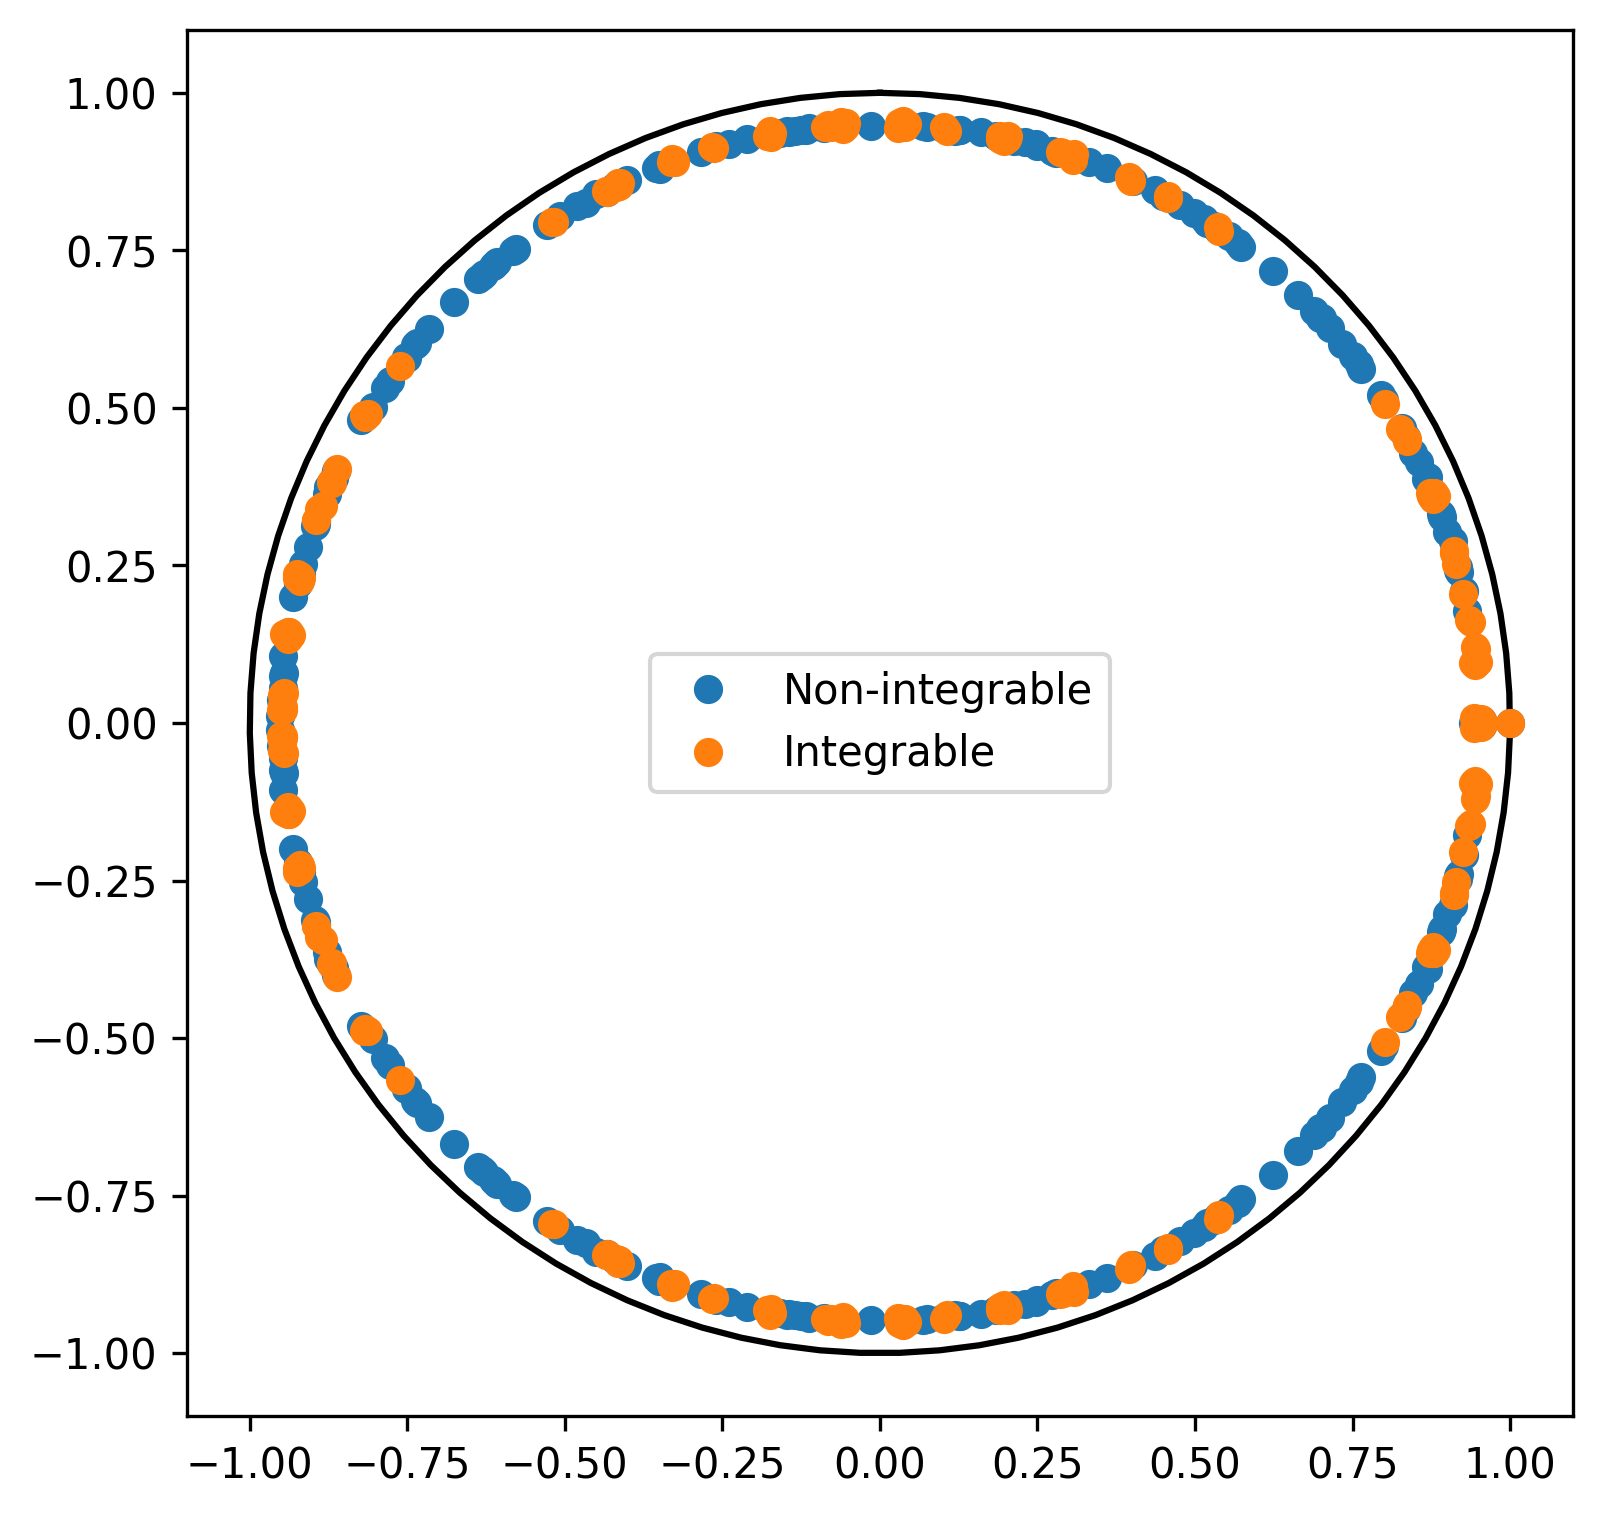

In [29]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
U_nonint = circuit_to_matrix(nonintegrable_circuit(n,2))
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
circuit_int = integrable_circuit(n,2) 
U_int = circuit_to_matrix(circuit_int)
print(circuit_int)

np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

channel_target1 = DilutedKrausMap(U=U_nonint, c=0.95, kraus_part=KrausMap(d,rank=2))
channel_target2 = DilutedKrausMap(U=U_int, c=0.95, kraus_part=KrausMap(d,rank=2))

spectrum1 = channel_spectrum(channel_target1)
spectrum2 = channel_spectrum(channel_target2)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum1[:,0], spectrum1[:,1], "o")
plt.plot(spectrum2[:,0], spectrum2[:,1], "o")
plt.legend(["_", "Non-integrable", "Integrable"])

In [28]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list5 = []

for i in tqdm(range(1000)):
    U = circuit_to_matrix(integrable_circuit(n, 2))
    channel_target = DilutedKrausMap(U=U, c=0.9, kraus_part=KrausMap(d,rank=2))
    spectrum = channel_spectrum(channel_target, use_coords=False, keep_real=False)
    z_list5.extend(complex_spacing_ratio(spectrum))

z_list5 = np.array(z_list5)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

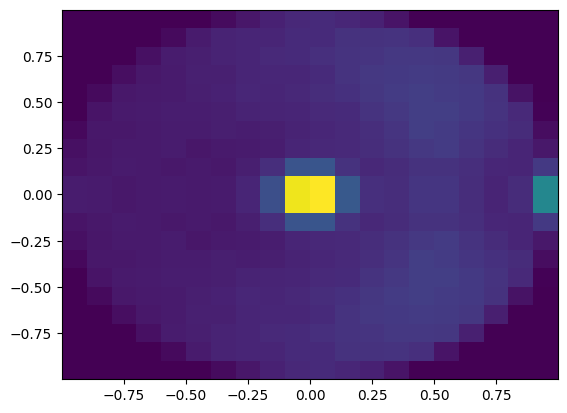

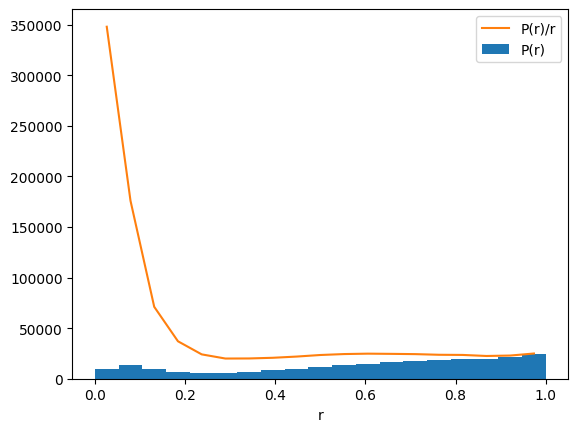

In [ ]:
plt.hist2d(np.real(z_list5), np.imag(z_list5), bins=20)
plt.show()
bins = np.linspace(0, 1, 20)
bins_center = (bins[1:] + bins[:-1])/2
radial = plt.hist(np.abs(z_list5), bins=bins)[0]
plt.plot(bins_center, radial/bins_center)
plt.legend(["P(r)/r", "P(r)"])
plt.xlabel("r")
plt.show()

In [ ]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list6 = []

for i in tqdm(range(1000)):
    U = circuit_to_matrix(nonintegrable_circuit(n, 2))
    channel_target = DilutedKrausMap(U=U, c=0.9, kraus_part=KrausMap(d,rank=2))
    spectrum = channel_spectrum(channel_target, use_coords=False, keep_real=False)
    z_list6.extend(complex_spacing_ratio(spectrum))

z_list6 = np.array(z_list6)

  0%|          | 0/1000 [00:00<?, ?it/s]

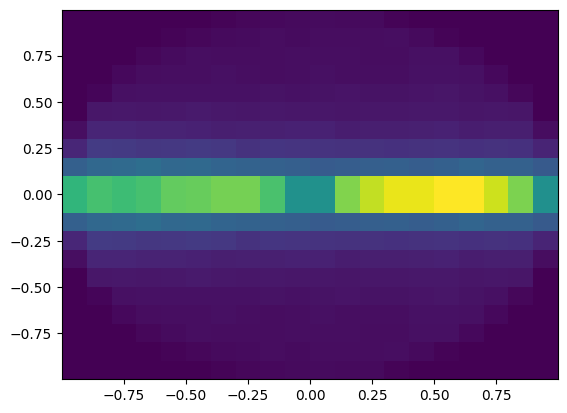

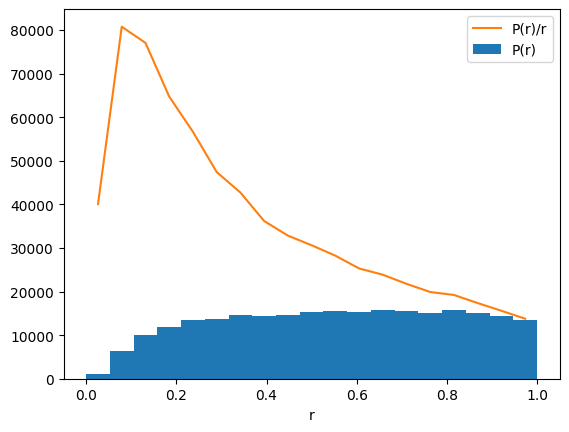

In [ ]:
plt.hist2d(np.real(z_list6), np.imag(z_list6), bins=20)
plt.show()
bins = np.linspace(0, 1, 20)
bins_center = (bins[1:] + bins[:-1])/2
radial = plt.hist(np.abs(z_list6), bins=bins)[0]
plt.plot(bins_center, radial/bins_center)
plt.legend(["P(r)/r", "P(r)"])
plt.xlabel("r")
plt.show()

## p = 0.85

c:\Program Files\Anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\krisw\AppData\Local\Temp\ipykernel_25324\1588414932.py:33: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x0000023FD97EADA0> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "Non-integrable", "Integrable"])


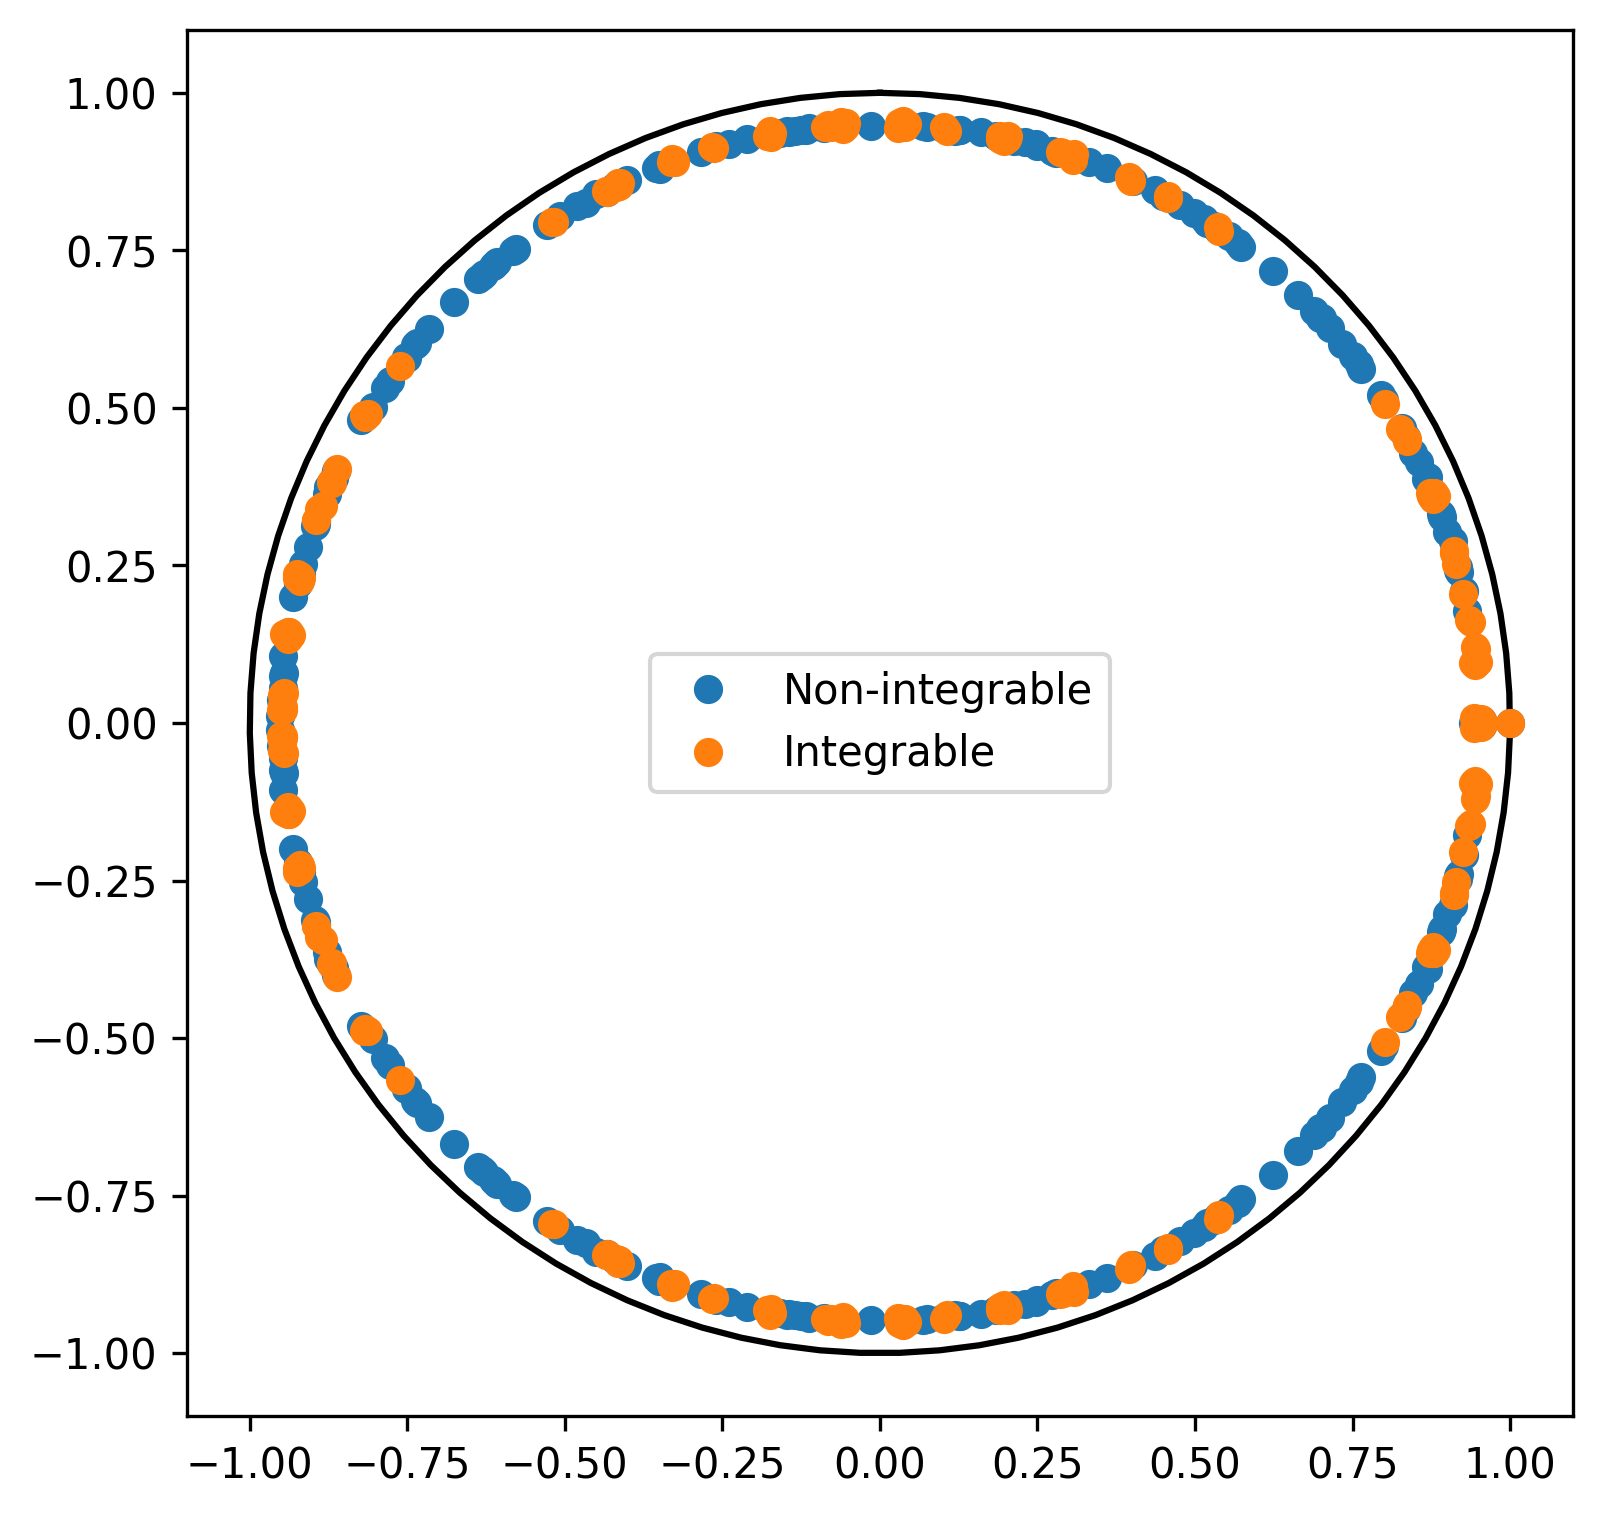

In [6]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
U_nonint = circuit_to_matrix(nonintegrable_circuit(n,2))
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
circuit_int = integrable_circuit(n,2) 
U_int = circuit_to_matrix(circuit_int)

np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

channel_target1 = DilutedKrausMap(U=U_nonint, c=0.95, kraus_part=KrausMap(d,rank=2))
channel_target2 = DilutedKrausMap(U=U_int, c=0.95, kraus_part=KrausMap(d,rank=2))

spectrum1 = channel_spectrum(channel_target1)
spectrum2 = channel_spectrum(channel_target2)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum1[:,0], spectrum1[:,1], "o")
plt.plot(spectrum2[:,0], spectrum2[:,1], "o")
plt.legend(["_", "Non-integrable", "Integrable"])

In [3]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list1 = []

for i in tqdm(range(1000)):
    U = circuit_to_matrix(integrable_circuit(n, 2))
    channel_target = DilutedKrausMap(U=U, c=0.85, kraus_part=KrausMap(d,rank=2))
    spectrum = channel_spectrum(channel_target, use_coords=False, keep_real=False)
    z_list1.extend(complex_spacing_ratio(spectrum))

z_list1 = np.array(z_list1)

  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\krisw\Documents\ModelNISQ\notebooks\experiments\../../src_tf\spectrum.py:91: RuntimeWarning: invalid value encountered in cdouble_scalars
  z = (spectrum[idx_NN] - spectrum[i]) / (spectrum[idx_NNN] - spectrum[i])
c:\Users\krisw\Documents\ModelNISQ\notebooks\experiments\../../src_tf\spectrum.py:91: RuntimeWarning: divide by zero encountered in cdouble_scalars
  z = (spectrum[idx_NN] - spectrum[i]) / (spectrum[idx_NNN] - spectrum[i])


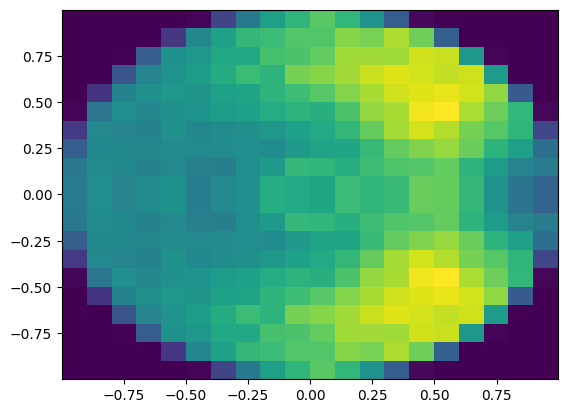

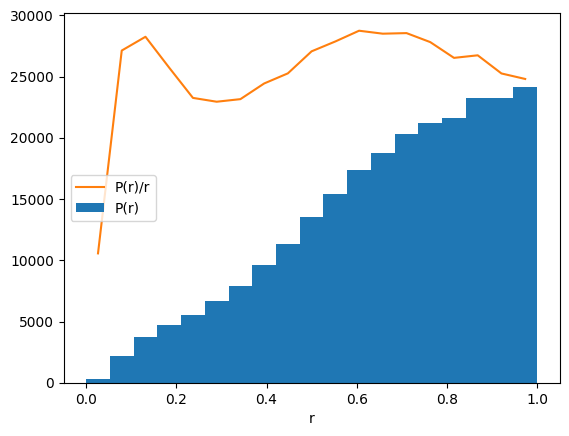

In [6]:
plt.hist2d(np.real(z_list1), np.imag(z_list1), bins=20)
plt.show()
bins = np.linspace(0, 1, 20)
bins_center = (bins[1:] + bins[:-1])/2
radial = plt.hist(np.abs(z_list1), bins=bins)[0]
plt.plot(bins_center, radial/bins_center)
plt.legend(["P(r)/r", "P(r)"])
plt.xlabel("r")
plt.show()

In [8]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list2 = []

for i in tqdm(range(1000)):
    U = circuit_to_matrix(nonintegrable_circuit(n, 2))
    channel_target = DilutedKrausMap(U=U, c=0.85, kraus_part=KrausMap(d,rank=2))
    spectrum = channel_spectrum(channel_target, use_coords=False, keep_real=False)
    z_list2.extend(complex_spacing_ratio(spectrum))

z_list2 = np.array(z_list2)

  0%|          | 0/1000 [00:00<?, ?it/s]

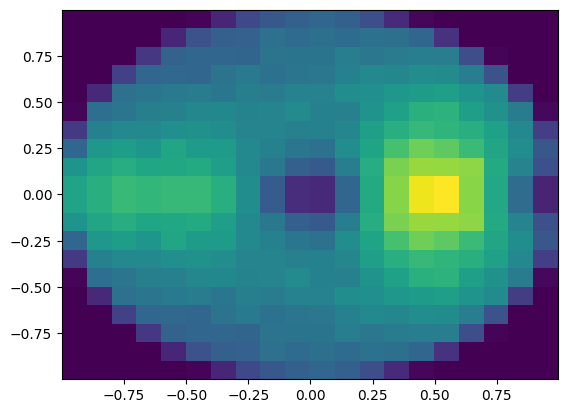

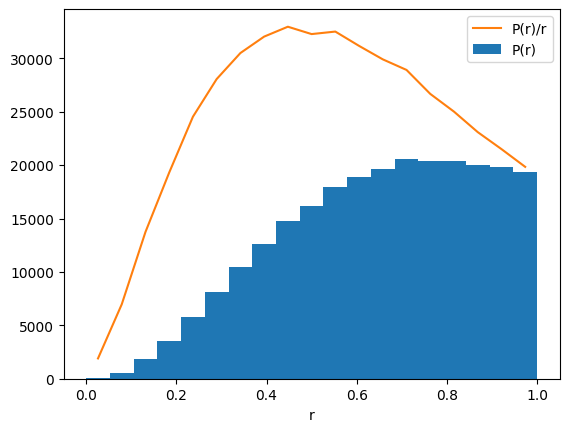

In [10]:
plt.hist2d(np.real(z_list2), np.imag(z_list2), bins=20)
plt.show()
bins = np.linspace(0, 1, 20)
bins_center = (bins[1:] + bins[:-1])/2
radial = plt.hist(np.abs(z_list2), bins=bins)[0]
plt.plot(bins_center, radial/bins_center)
plt.legend(["P(r)/r", "P(r)"])
plt.xlabel("r")
plt.show()

     ┌──────────────┐┌────────────┐┌─────────────┐┌─────────────┐»
q_0: ┤ Rz(-0.78829) ├┤0           ├┤ Rz(-2.1613) ├┤ Rz(0.63532) ├»
     └┬────────────┬┘│  iswap^0.5 │├─────────────┤└┬────────────┤»
q_1: ─┤ Rz(2.8319) ├─┤1           ├┤ Rz(-2.1615) ├─┤0           ├»
      ├────────────┤ ├────────────┤├─────────────┤ │  iswap^0.5 │»
q_2: ─┤ Rz(1.4577) ├─┤0           ├┤ Rz(-2.7766) ├─┤1           ├»
     ┌┴────────────┤ │  iswap^0.5 │└┬────────────┤ ├────────────┤»
q_3: ┤ Rz(0.61989) ├─┤1           ├─┤ Rz(2.3008) ├─┤ Rz(2.9525) ├»
     └─────────────┘ └────────────┘ └────────────┘ └────────────┘»
«                    ┌────────────┐ ┌────────────┐              
«q_0: ───────────────┤0           ├─┤ Rz(2.0888) ├──────────────
«      ┌────────────┐│  iswap^0.5 │┌┴────────────┤┌────────────┐
«q_1: ─┤ Rz(1.3074) ├┤1           ├┤ Rz(-1.8074) ├┤0           ├
«     ┌┴────────────┤├────────────┤├─────────────┤│  iswap^0.5 │
«q_2: ┤ Rz(-3.0123) ├┤0           ├┤ Rz(-1.9992) ├┤1           ├
«     └

c:\Program Files\Anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\krisw\AppData\Local\Temp\ipykernel_19884\2522443462.py:34: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x000001E6E3DAA470> starts with '_'. It is thus excluded from the legend.
  plt.legend(["_", "Non-integrable", "Integrable"])


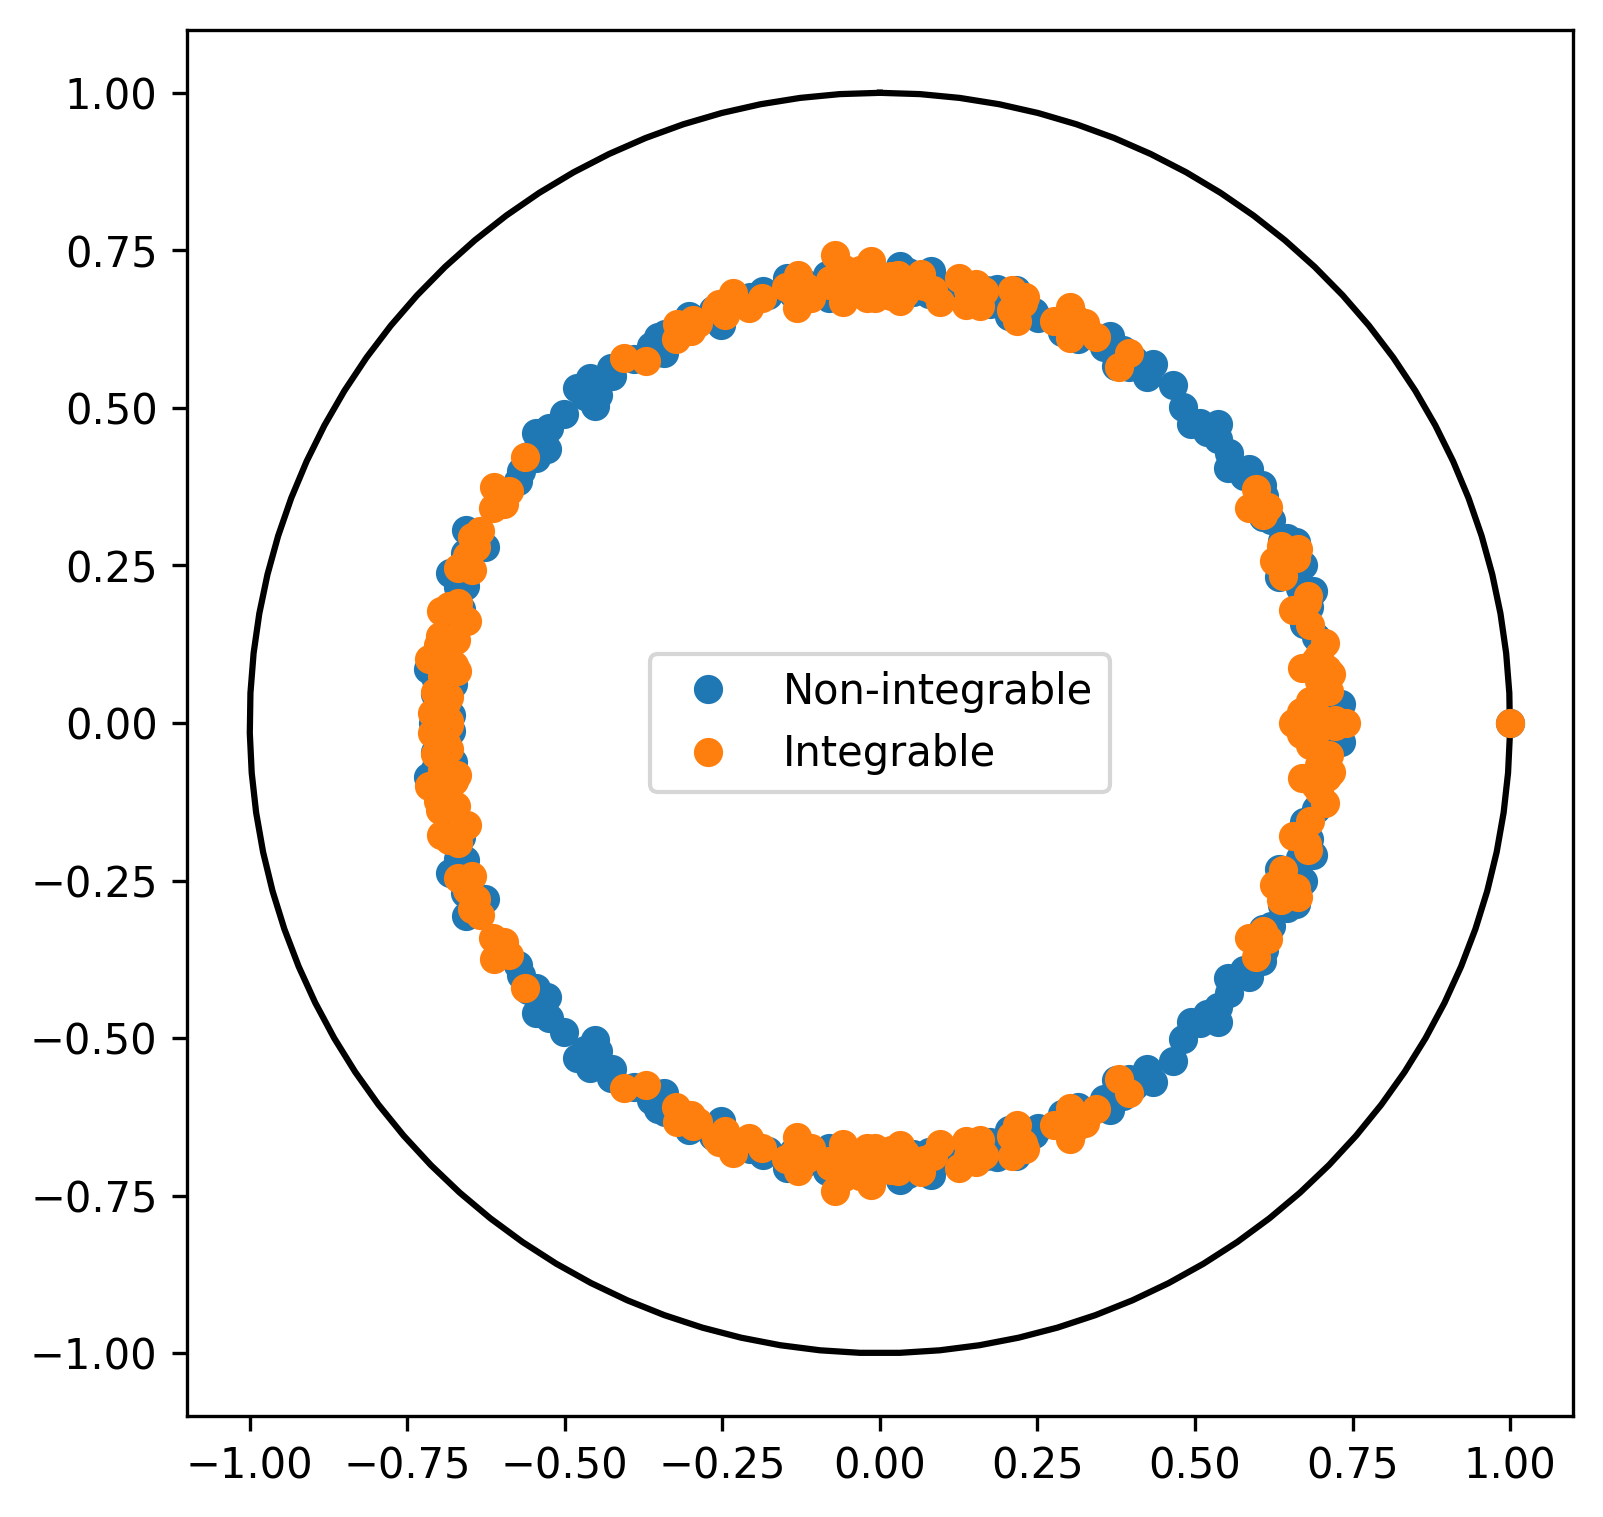

In [17]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
U_nonint = circuit_to_matrix(nonintegrable_circuit(n,2))
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
circuit_int = integrable_circuit(n,2) 
U_int = circuit_to_matrix(circuit_int)
print(circuit_int)

np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

channel_target1 = DilutedKrausMap(U=U_nonint, c=0.7, kraus_part=KrausMap(d,rank=4))
channel_target2 = DilutedKrausMap(U=U_int, c=0.7, kraus_part=KrausMap(d,rank=4))

spectrum1 = channel_spectrum(channel_target1)
spectrum2 = channel_spectrum(channel_target2)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum1[:,0], spectrum1[:,1], "o")
plt.plot(spectrum2[:,0], spectrum2[:,1], "o")
plt.legend(["_", "Non-integrable", "Integrable"])

In [13]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list3 = []

for i in tqdm(range(1000)):
    U = circuit_to_matrix(integrable_circuit(n, 2))
    channel_target = DilutedKrausMap(U=U, c=0.7, kraus_part=KrausMap(d,rank=4))
    spectrum = channel_spectrum(channel_target, use_coords=False, keep_real=False)
    z_list3.extend(complex_spacing_ratio(spectrum))

z_list3 = np.array(z_list3)

  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\krisw\Documents\ModelNISQ\notebooks\experiments\../../src_tf\spectrum.py:91: RuntimeWarning: invalid value encountered in cdouble_scalars
  z = (spectrum[idx_NN] - spectrum[i]) / (spectrum[idx_NNN] - spectrum[i])
c:\Users\krisw\Documents\ModelNISQ\notebooks\experiments\../../src_tf\spectrum.py:91: RuntimeWarning: divide by zero encountered in cdouble_scalars
  z = (spectrum[idx_NN] - spectrum[i]) / (spectrum[idx_NNN] - spectrum[i])


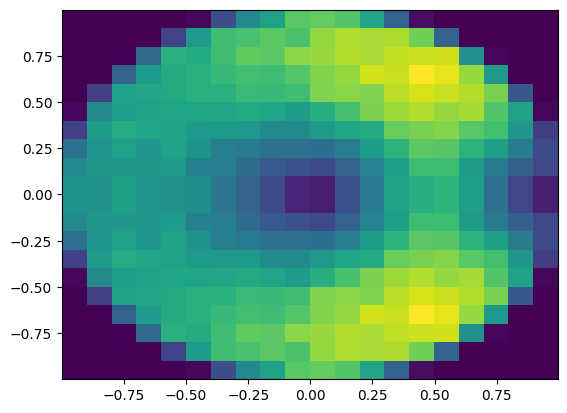

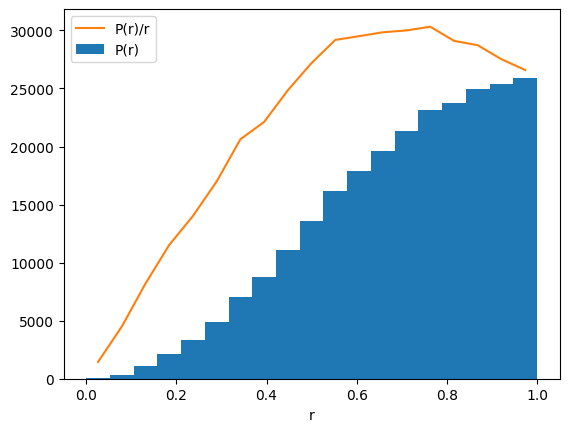

In [14]:
plt.hist2d(np.real(z_list3), np.imag(z_list3), bins=20)
plt.show()
bins = np.linspace(0, 1, 20)
bins_center = (bins[1:] + bins[:-1])/2
radial = plt.hist(np.abs(z_list3), bins=bins)[0]
plt.plot(bins_center, radial/bins_center)
plt.legend(["P(r)/r", "P(r)"])
plt.xlabel("r")
plt.show()

In [15]:
n = 4
d = 2**n

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

z_list4 = []

for i in tqdm(range(1000)):
    U = circuit_to_matrix(nonintegrable_circuit(n, 2))
    channel_target = DilutedKrausMap(U=U, c=0.7, kraus_part=KrausMap(d,rank=4))
    spectrum = channel_spectrum(channel_target, use_coords=False, keep_real=False)
    z_list4.extend(complex_spacing_ratio(spectrum))

z_list4 = np.array(z_list4)

  0%|          | 0/1000 [00:00<?, ?it/s]

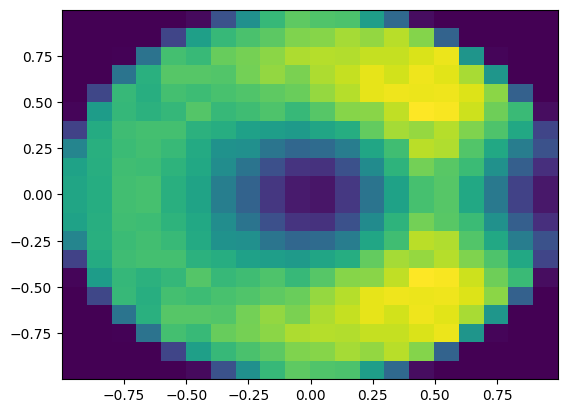

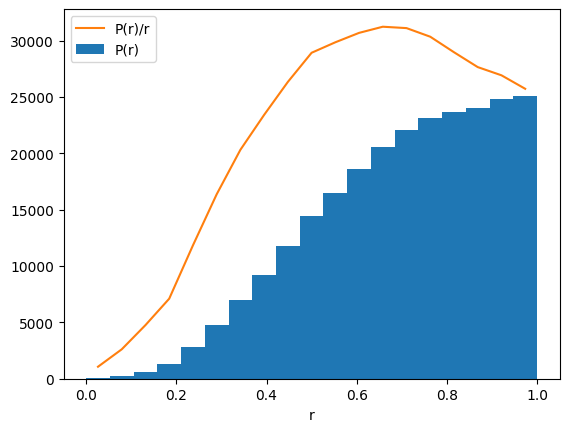

In [16]:
plt.hist2d(np.real(z_list4), np.imag(z_list4), bins=20)
plt.show()
bins = np.linspace(0, 1, 20)
bins_center = (bins[1:] + bins[:-1])/2
radial = plt.hist(np.abs(z_list4), bins=bins)[0]
plt.plot(bins_center, radial/bins_center)
plt.legend(["P(r)/r", "P(r)"])
plt.xlabel("r")
plt.show()

## Stability of Recovered Model

In [5]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 4
d = 2**n

model_list = []
channel_target_list = []

for i in tqdm(range(10)):
    U = circuit_to_matrix(integrable_circuit(n, 2))
    channel_target = DilutedKrausMap(U=U, c=0.85, kraus_part=KrausMap(d,rank=2))
    
    inputs_map, targets_map = generate_map_data(channel_target, IdealSPAM(d), N_map= 10000-6**n, shots=1024)

    model = ModelQuantumMap(channel = KrausMap(d = d, 
                                                rank = 3,
                                                ),
                            loss_function = ProbabilityMSE(),
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            logger = Logger(loss_function = ProbabilityMSE(),
                                            loss_function_val = channel_fidelity_loss),
                        )

    model.train(inputs = inputs_map,
                targets = targets_map,
                inputs_val = None,
                targets_val = [channel_target],
                num_iter = 2000,
                N = 500,
                verbose=True
                )

    channel_target_list.append(channel_target)
    model_list.append(model)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.150060206952257 -0.013046794093498163
0.4659248004005963 -0.3042718137804324
0.12251653267873414 -0.6128653490776363
0.04521098214119313 -0.7391666771403388
0.03232613301230924 -0.7901341192330406
0.02884210106995397 -0.8245318347689318
0.026014310960516533 -0.8561948964586543
0.023733983123036623 -0.8860166337948338
0.02243756964138727 -0.9121026613365762
0.02089442345780077 -0.933398824669317
0.019015680761138225 -0.9504601084282353
0.017744196571448708 -0.964043024148508
0.01639941349349933 -0.9743448286174696
0.016098426926963217 -0.9820584519076294
0.01576821188512466 -0.9876995647934393
0.014852742759898476 -0.9915578149334787
0.014572255384738778 -0.9942326196129505
0.014244995978505492 -0.9957832899066003
0.014236657715366658 -0.9969732567867207
0.01379625359662888 -0.9975893149300099
0.01413603693065808 -0.9979481871344507


  0%|          | 0/2000 [00:00<?, ?it/s]

1.4072514888606273 -0.005581961635331579
0.6296999956362888 -0.17790421120207758
0.1431583695080002 -0.5583813474966148
0.050163429812617295 -0.6938336139313958
0.035582533515909426 -0.741121294841206
0.03097365667942095 -0.7683190934308006
0.028993044662356218 -0.7919383020095385
0.026289797086278224 -0.8139652708766881
0.024793182934998277 -0.8321661582035834
0.02355489500771358 -0.8481444101073375
0.02250119328277516 -0.863057879992538
0.02112094447885159 -0.8770986605773446
0.021119504516656062 -0.8913541080205283
0.01979332849307653 -0.9092876019814136
0.01868262373538968 -0.9264340343477667
0.01746962596638459 -0.9424472283201258
0.017018673220649747 -0.9561243003916245
0.01636859356924012 -0.9678122069188221
0.016020931902501506 -0.9771761973058432
0.01442833448168172 -0.9837846494669957
0.014383876654672036 -0.9885554570242555


  0%|          | 0/2000 [00:00<?, ?it/s]

1.2811711018358856 -0.008217271344575198
0.5345987858686292 -0.26387152921060436
0.11848149298665467 -0.6229570765768659
0.040800910004735375 -0.7470271997325996
0.030579964964237035 -0.7947419541988249
0.028341503780223844 -0.828742218585469
0.0255267875580378 -0.856227580417192
0.0240543139410484 -0.8824283776646037
0.021905530383344363 -0.9066323196423872
0.020237176608370645 -0.9288783210828744
0.019554442573977794 -0.9472768895587966
0.01705992486695129 -0.9622138033783341
0.01734572180363078 -0.9731059671369061
0.015591490203814251 -0.9809150365754932
0.01556205884714321 -0.9863896885388882
0.014659186514525413 -0.990322759395615
0.01382076961015993 -0.993049330585855
0.013692225893820648 -0.9948315601618103
0.014000181394051223 -0.9960509388764173
0.014283866713204385 -0.9969682778307032
0.013885928731957065 -0.9976289032936936


  0%|          | 0/2000 [00:00<?, ?it/s]

1.1659012489738823 -0.01581201556674803
0.496827503455257 -0.2917306506101079
0.13091375869563912 -0.6040493356644238
0.04742854304347439 -0.7286921849850241
0.034374149677079385 -0.7839860168721359
0.02902646247936489 -0.8257778161743831
0.02600091526784675 -0.8623413978250258
0.023158861379407453 -0.8948069266832294
0.020954668372747676 -0.921215452849582
0.020230898414260314 -0.9419871229741548
0.018510112956910563 -0.9578342900761427
0.0164882229914624 -0.9696657891766222
0.01587217112329997 -0.9785245952082469
0.015435263759546083 -0.9845988786354476
0.014670649010086863 -0.989040880683723
0.014239748589118369 -0.9921460277247431
0.014409396574345265 -0.9942486159438367
0.013777157983278762 -0.9957115663419419
0.013669735326943867 -0.9967924516031483
0.01432138077701854 -0.9974492998711891
0.014255173944969456 -0.9978568981501243


  0%|          | 0/2000 [00:00<?, ?it/s]

1.2283730566036015 -0.00543931479679157
0.6138224298549078 -0.18810716780674544
0.1599117816350812 -0.5388024414941504
0.05417474643456047 -0.6976516088375445
0.03523013247054458 -0.7615806913943436
0.03029643286518 -0.8047238034253137
0.027650887220869245 -0.8398814050659197
0.02565963638393604 -0.8704116031673789
0.023692165401703054 -0.8966463684230415
0.021954186785110515 -0.919034757343825
0.020148338096053302 -0.9375686273547538
0.01859076630764516 -0.9526153812815858
0.017790333216174327 -0.9648558009284932
0.016756325548420017 -0.974004619949846
0.016150178179973985 -0.9815780744306928
0.015766170593794752 -0.9869566002365133
0.014588984376864619 -0.990727927039621
0.014540261676872387 -0.9934475098469581
0.014107759967939091 -0.9952576633980771
0.014215568932028065 -0.9964127974402158
0.014470136151546758 -0.9972765529812876


  0%|          | 0/2000 [00:00<?, ?it/s]

1.2378413091359106 -0.009458795395550848
0.5456439366510413 -0.23515341516792132
0.13454529498413967 -0.5810696729225678
0.04587611897719705 -0.7159218299791195
0.0331539592799824 -0.768739697161171
0.028681853879469706 -0.8076895624457928
0.02615112498449204 -0.8435586573098205
0.02475134921935874 -0.87532698468839
0.02287752652404234 -0.9033684808872068
0.020759325157931344 -0.9277652563603297
0.019333009240952378 -0.9471746324633942
0.018058889814639486 -0.9620327678593245
0.016486070718245118 -0.9728700678162208
0.015943297698965235 -0.9804628080791914
0.01531857746747583 -0.9856982243408765
0.014717168826517255 -0.989508178943339
0.014505814200925699 -0.9922696690336466
0.014139330707123378 -0.9943293192787849
0.014359542673497247 -0.9955908039520289
0.013519921172769128 -0.9965549575571232
0.014450986520848932 -0.997149810076201


  0%|          | 0/2000 [00:00<?, ?it/s]

1.1305063730892349 -0.007558595013862056
0.5497393400175793 -0.22450440658976675
0.11465259373073378 -0.6111891202178734
0.04262690586638661 -0.7448514743342236
0.03149949372140674 -0.804473202288368
0.026952482002438747 -0.8466264889070281
0.024637114476461178 -0.8783650496747216
0.02409941434887125 -0.9039501426915028
0.021831673298949923 -0.9253169784996239
0.019120002386587075 -0.9433036979988612
0.018230031985263066 -0.9580845645178638
0.017060182988497048 -0.9700772133634198
0.016378657358693222 -0.9792221946198423
0.015477760248784866 -0.9859286424873271
0.0148915798508255 -0.9905922610469552
0.01443506536363513 -0.9935962251765788
0.014244289364584809 -0.9954467541151595
0.013532515500100576 -0.9967660557289101
0.014190862492260196 -0.9974584765469612
0.014371191935044924 -0.9978684720768392
0.013843627092572064 -0.9982006003477302


  0%|          | 0/2000 [00:00<?, ?it/s]

1.3048250467452662 -0.005546526222737451
0.6618943716740832 -0.14515368228825173
0.1848169399501773 -0.5198310877355897
0.06382547163848569 -0.6978405239807055
0.03523282653832749 -0.773694542699968
0.029837464696369664 -0.8164938808900382
0.027404195865692683 -0.8500152382196134
0.023708431161247313 -0.8821740388975208
0.021913895927274815 -0.9099028282059642
0.01911768008112041 -0.9321334619154458
0.01839101090256572 -0.9502477964206698
0.01686416297351181 -0.9643655641982154
0.01629150048653191 -0.9753350181742272
0.01533609749045245 -0.9832612241331594
0.0152464755545163 -0.9886304740221853
0.01426861673381777 -0.9922324773961173
0.014381785131140046 -0.9945184208859827
0.014055322931220403 -0.9962088434588292
0.0142082133313379 -0.9970621468071854
0.013992109557630637 -0.9976522799767539
0.013709690841090853 -0.9980318040234429


  0%|          | 0/2000 [00:00<?, ?it/s]

1.157235970870873 -0.012437326161444943
0.5130860634891954 -0.23911699646037857
0.12085501575451016 -0.6006664674826659
0.04967583416181486 -0.7305502290719358
0.03277146238804213 -0.7943643112730884
0.026940963567722093 -0.8367706945973034
0.02505355551396455 -0.8706850417051797
0.023142640242565692 -0.8991884443330406
0.021703459616676312 -0.9228981470744143
0.019119646996478272 -0.9419143592011564
0.01811788285993848 -0.9571290511849132
0.017161091481139253 -0.9685563179474882
0.016345232135665612 -0.9772187588294073
0.016040636155330076 -0.9838146640851899
0.015089286536784563 -0.9885625246334927
0.014571220581595106 -0.9919020752662825
0.014109636730652415 -0.9942506970233514
0.014265419099927594 -0.9958278134595212
0.014078703984668216 -0.9968498252306145
0.013473715309442578 -0.9974323847960604
0.01345756182893804 -0.9979570930095092


  0%|          | 0/2000 [00:00<?, ?it/s]

1.242094653250214 -0.005006371117862843
0.6467668648970262 -0.14268111560377297
0.20741440068078532 -0.4976593379612303
0.06199620384591896 -0.6814576225447545
0.03772784837702338 -0.7593105242884574
0.030157240362123125 -0.8093654942106141
0.02688137752065766 -0.8471160845865827
0.024261331353635444 -0.8784792094411858
0.02268906540614427 -0.9065669609403902
0.020819956089925696 -0.9303846173933384
0.01922037553541638 -0.9494108790405749
0.017497848651380096 -0.9634028907449393
0.016449596185785897 -0.97422135454359
0.015333326294336612 -0.9818389444471755
0.014794045993102592 -0.9873472058774713
0.01470181452757809 -0.9913008422160392
0.014072583148041218 -0.99405022339925
0.013685406042207788 -0.9956879642969341
0.013681558274769025 -0.996793578600728
0.013920927137877506 -0.9975188725871069
0.01372515047916874 -0.9980497736739048


In [11]:
z_target_list = []
z_model_list = []

for model, channel_target in zip(model_list, channel_target_list):
    spectrum_target = channel_spectrum(channel_target, use_coords=False, keep_real=False)
    spectrum_model = channel_spectrum(model.channel, use_coords=False, keep_real=False)

    z_target = complex_spacing_ratio(spectrum_target)
    z_model1 = complex_spacing_ratio(spectrum_model)

    z_target_list.extend(z_target)
    z_model_list.extend(z_model1)


c:\Users\krisw\Documents\ModelNISQ\notebooks\experiments\../../src_tf\spectrum.py:91: RuntimeWarning: invalid value encountered in cdouble_scalars
  z = (spectrum[idx_NN] - spectrum[i]) / (spectrum[idx_NNN] - spectrum[i])
c:\Users\krisw\Documents\ModelNISQ\notebooks\experiments\../../src_tf\spectrum.py:91: RuntimeWarning: divide by zero encountered in cdouble_scalars
  z = (spectrum[idx_NN] - spectrum[i]) / (spectrum[idx_NNN] - spectrum[i])


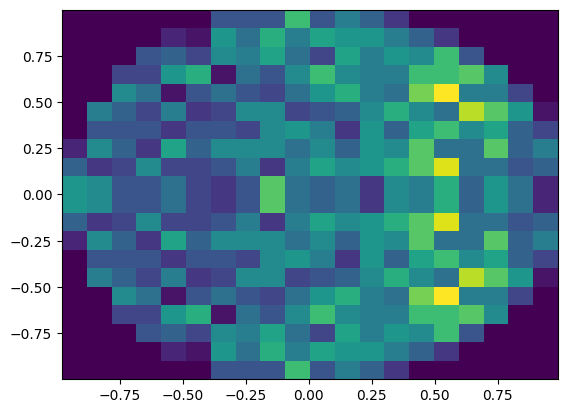

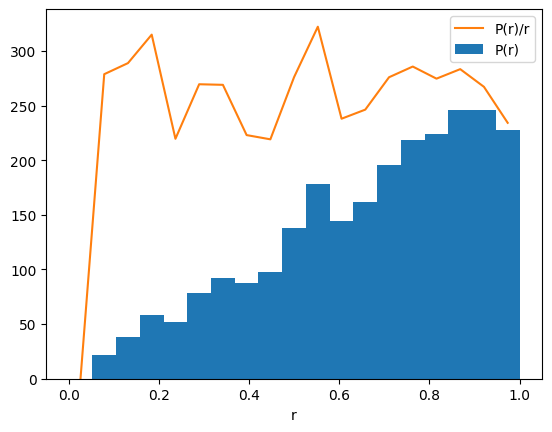

In [12]:
plt.hist2d(np.real(z_target_list), np.imag(z_target_list), bins=20)
plt.show()
bins = np.linspace(0, 1, 20)
bins_center = (bins[1:] + bins[:-1])/2
radial = plt.hist(np.abs(z_target_list), bins=bins)[0]
plt.plot(bins_center, radial/bins_center)
plt.legend(["P(r)/r", "P(r)"])
plt.xlabel("r")
plt.show()

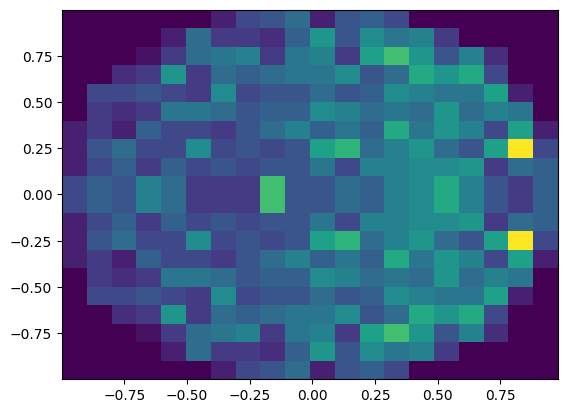

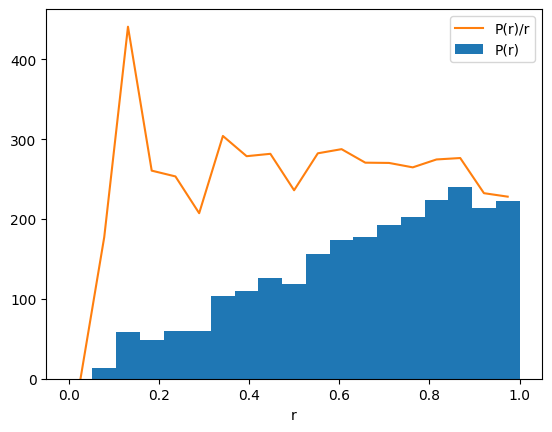

In [13]:
plt.hist2d(np.real(z_model_list), np.imag(z_model_list), bins=20)
plt.show()
bins = np.linspace(0, 1, 20)
bins_center = (bins[1:] + bins[:-1])/2
radial = plt.hist(np.abs(z_model_list), bins=bins)[0]
plt.plot(bins_center, radial/bins_center)
plt.legend(["P(r)/r", "P(r)"])
plt.xlabel("r")
plt.show()

In [14]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 4
d = 2**n

model_list2 = []
channel_target_list2 = []

for i in tqdm(range(10)):
    U = circuit_to_matrix(nonintegrable_circuit(n, 2))
    channel_target = DilutedKrausMap(U=U, c=0.85, kraus_part=KrausMap(d,rank=2))
    
    inputs_map, targets_map = generate_map_data(channel_target, IdealSPAM(d), N_map= 10000-6**n, shots=1024)

    model = ModelQuantumMap(channel = KrausMap(d = d, 
                                                rank = 3,
                                                ),
                            loss_function = ProbabilityMSE(),
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            logger = Logger(loss_function = ProbabilityMSE(),
                                            loss_function_val = channel_fidelity_loss),
                        )

    model.train(inputs = inputs_map,
                targets = targets_map,
                inputs_val = None,
                targets_val = [channel_target],
                num_iter = 2000,
                N = 500,
                verbose=True
                )

    channel_target_list2.append(channel_target)
    model_list2.append(model)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.146902017189507 -0.005115982462883736
0.564698592863399 -0.21210794259553226
0.11363093181262883 -0.6082183882898925
0.04169281145053817 -0.7176842724794937
0.032034205079064564 -0.7540134709553862
0.028978948136417614 -0.7770110506591266
0.02774031624945039 -0.7996021302174069
0.02707139576991922 -0.8270609705140616
0.024556109507545328 -0.857022584799024
0.023465227301899434 -0.8881732045725355
0.021619718264607856 -0.9183338982286492
0.019321399511803443 -0.9448652686823276
0.01762776408101056 -0.9641600914819063
0.016309224066800524 -0.9771949060120395
0.016072799749006206 -0.9856139414274624
0.014610071001535854 -0.9909888132510225
0.014151846208060473 -0.9942976387107867
0.014164240830947927 -0.9963151311795563
0.013934329025820943 -0.9974781205610972
0.014038974953383567 -0.998060681827199
0.014122803191570745 -0.9983599721495455


  0%|          | 0/2000 [00:00<?, ?it/s]

1.1701299678309642 -0.010926824008212176
0.464471826912472 -0.2829232325616141
0.09425098267680151 -0.6293709732491345
0.041459296400749863 -0.7414315857987571
0.03187339225155036 -0.7924310556757493
0.027640663647008873 -0.832117273468905
0.02467017048011945 -0.8700153591635726
0.022321211613311062 -0.9038452856593581
0.019990010617424687 -0.9324278497538554
0.018554870541515812 -0.9544729183557802
0.01636926211106671 -0.9703673976752417
0.015568659057243245 -0.9812214349499001
0.014316940894145373 -0.9881824829391008
0.01401671086548067 -0.9925860300854196
0.014148557865893143 -0.9951827999939485
0.013704392360853676 -0.9967294112695241
0.013467051437961475 -0.9976199246020263
0.013704827340540375 -0.9982003063815793
0.01375741832457555 -0.9984556700551119
0.013289982485300101 -0.9985680267491842
0.01381222264323668 -0.9986557958507658


  0%|          | 0/2000 [00:00<?, ?it/s]

1.1047135888329211 -0.004431653963750292
0.6749578148872142 -0.10029163297639704
0.19586448611903431 -0.48117768247111137
0.056268741102698985 -0.706025273896339
0.032994707131155154 -0.7801423000309513
0.02849267132978158 -0.8220153799552631
0.02514446216795082 -0.8538956405325401
0.024141039100851948 -0.882049207563154
0.02177013185649961 -0.9081721782825372
0.020503236773562677 -0.9310143287114535
0.018682849125610416 -0.950269029409392
0.016567947814953528 -0.9653762109574199
0.016374472856145957 -0.9768872916552481
0.015158988711546648 -0.984699659612235
0.014869790315992138 -0.9900168378036831
0.014356536246467719 -0.9934980628214878
0.013667099594504094 -0.9956326218045282
0.014007513328398584 -0.9969612099368556
0.013923306943323983 -0.9978167029127718
0.014148987948025759 -0.9981806571332391
0.01416892154330683 -0.9985152673119665


  0%|          | 0/2000 [00:00<?, ?it/s]

1.2295986543369382 -0.005467454370574999
0.6719198410158326 -0.16193627919709258
0.1450983278653672 -0.572382122472285
0.044696631884032584 -0.710963924895824
0.032500681731953536 -0.7561748932883593
0.029990465305541596 -0.7860554442296581
0.028301415422273483 -0.8149732352876287
0.02545742530525206 -0.8423702446371206
0.025332427255297746 -0.8690949054198688
0.02332082135829852 -0.8932671715403481
0.02170021582764886 -0.9153856813558485
0.019886504248363784 -0.9341071092345088
0.018986313854612937 -0.9498497791537791
0.017216852453135933 -0.9627416282658894
0.01627495227247185 -0.9729571987641966
0.015087257139309225 -0.9806106999826487
0.015094518660513721 -0.9861514720558143
0.0143967348383174 -0.9901855249254952
0.01384429684223192 -0.9929963756322555
0.014686592158850587 -0.9947658193161354
0.01404165049271726 -0.9961134530825199


  0%|          | 0/2000 [00:00<?, ?it/s]

1.139676248706651 -0.010300885888096393
0.5309159971544639 -0.2654796245522
0.09845413881506662 -0.6212414661123213
0.04219102354970922 -0.7253579247079768
0.03285625594519493 -0.7651185749200284
0.028846422831478803 -0.7939447539988528
0.02677791766852352 -0.8176626376624404
0.024900941721914673 -0.8401011950886759
0.022756538514228476 -0.8619404486468561
0.021875996548748177 -0.8844970060461345
0.020535415720468287 -0.9082482853475408
0.019737022725788412 -0.9320530041758256
0.018385024002265927 -0.9530267795861274
0.017048525253780783 -0.9692358574028492
0.015999649122784072 -0.9802816463024157
0.015106050333304285 -0.9872951325930276
0.014471113261961538 -0.9917899970665078
0.014230210894632589 -0.994497200837655
0.013727736896040696 -0.996257582683563
0.014057789774561687 -0.9972924725343003
0.014512231244788652 -0.99784519985062


  0%|          | 0/2000 [00:00<?, ?it/s]

1.1590802387884223 -0.002803256844019943
0.6332918740544132 -0.17000670123473074
0.1194489141539706 -0.5827539518655666
0.042552415944334385 -0.7219548404334912
0.031966769450433585 -0.7728766305528981
0.029126257885627487 -0.8083873692974969
0.026296889944877375 -0.8401668845720572
0.024066072309766495 -0.8716396381814822
0.022140925837944244 -0.901941342052696
0.020642140099166106 -0.928903614258208
0.018778394899367567 -0.9502188737828933
0.016446055902772875 -0.9662657957702693
0.015827313864361422 -0.9776028520613883
0.01529334334044718 -0.9855575491193411
0.014968683981381676 -0.9907305503631668
0.01423049091292552 -0.9939920009719996
0.014053120496036546 -0.9959754816412106
0.013725428880430348 -0.9971817268158722
0.014077940418175228 -0.997900727151513
0.013220364884548587 -0.9982510452279977
0.013675555059762135 -0.9985096417647206


  0%|          | 0/2000 [00:00<?, ?it/s]

1.2317010001855193 -0.003403713244127927
0.6806436634509013 -0.12559945263217434
0.1722786202022061 -0.5304576492618815
0.053152144441217845 -0.699854936918874
0.03476226004569226 -0.7579566299848257
0.029610826482933183 -0.7922953762623883
0.02722308890362242 -0.823934033370491
0.025116824776658518 -0.8563279014561772
0.023057050123803186 -0.8865995836699727
0.021358830236690288 -0.915189679454275
0.01939007098035138 -0.9386091985804773
0.018101988342095015 -0.9573883390109531
0.016730546143983296 -0.9711995962328513
0.01581846442526063 -0.9810103330633675
0.01452455926791351 -0.9875132307581764
0.014471723536724941 -0.9918087998092746
0.013917150646786988 -0.9946291813705783
0.013649211543414282 -0.9963762495485063
0.01448805114223335 -0.997339715670195
0.01431724887595335 -0.9979327182612445
0.013413735014271165 -0.9982592870244905


  0%|          | 0/2000 [00:00<?, ?it/s]

1.1368890637312525 -0.007715506478868114
0.5631122314169013 -0.22259126811247443
0.09011609534663188 -0.6305090221470282
0.04075450738059274 -0.7523159545989496
0.03161639366088802 -0.8028377194479079
0.029170659726242377 -0.8427458910520318
0.025875171153985497 -0.8779699108462539
0.022325213033713723 -0.9094405920007124
0.019927184658025992 -0.9354080348570729
0.018569447800830502 -0.9555180833274707
0.01704079767234224 -0.9706946700446858
0.015317650669773017 -0.9811769279571076
0.015366861510481559 -0.9882322883015995
0.01454655547886053 -0.992543423462228
0.014820894647867634 -0.9951914622862464
0.013936417274737623 -0.9966512814067332
0.013891833262094859 -0.9976051517157464
0.014041599943385967 -0.9981016586272594
0.014201964794606909 -0.9983358671293395
0.013982916435082678 -0.9986146254139643
0.014476221137089101 -0.9986634935352616


  0%|          | 0/2000 [00:00<?, ?it/s]

1.124409046803364 -0.009685889468222882
0.5009403820545929 -0.2981481554299988
0.07873370090137202 -0.6606089051095483
0.03718282209982954 -0.7513009031513379
0.030159554220057533 -0.7904043613731149
0.02726519234353824 -0.8183662809705885
0.0258051260213144 -0.8421866518882625
0.02459867051242866 -0.8631940937570718
0.023624323586719235 -0.8857702723831442
0.021178540662840802 -0.9083684560582217
0.01991891070787771 -0.9306715777378317
0.018518192520162076 -0.9504194370993047
0.017658861501629805 -0.9662041653754205
0.015973229425151905 -0.9780737897746558
0.01586428165452598 -0.9864296943768686
0.01497952263133203 -0.9915912030415764
0.013692152208339768 -0.9947675152690235
0.013717518931986628 -0.9965237754645105
0.014261377821781298 -0.9975552871231942
0.013585696625492154 -0.9980993150734184
0.01359001464473978 -0.9983599053230366


  0%|          | 0/2000 [00:00<?, ?it/s]

1.1555773792142354 -0.007324457542181523
0.5545287801752605 -0.22009504341205444
0.10418823066876312 -0.5956347957906628
0.04256186502571839 -0.7196199522987387
0.03178700144686479 -0.7650204206905182
0.028143565294416733 -0.7979852547914131
0.026767526342488794 -0.8253309205751111
0.024456142897945496 -0.8514601397601756
0.024086645444976847 -0.8775152343096748
0.022478783926219867 -0.903238500674093
0.02053242644594595 -0.9258659421758305
0.018872190774925204 -0.945262598967928
0.017801745470202673 -0.9607930975402441
0.015906825973694184 -0.9729314354169697
0.015351470652654275 -0.9817029617806348
0.014776413459980027 -0.9880128644077851
0.01469023406457246 -0.992133934189277
0.013898591055411543 -0.9946499257792705
0.013965701182375508 -0.996318907516362
0.013966545333659939 -0.9972632944798512
0.013917019165086426 -0.9979641710934902


In [17]:
z_target_list2 = []
z_model_list2 = []

for model, channel_target in zip(model_list2, channel_target_list2):
    spectrum_target = channel_spectrum(channel_target, use_coords=False, keep_real=False)
    spectrum_model = channel_spectrum(model.channel, use_coords=False, keep_real=False)

    z_target = complex_spacing_ratio(spectrum_target)
    z_model = complex_spacing_ratio(spectrum_model)

    z_target_list2.extend(z_target)
    z_model_list2.extend(z_model)


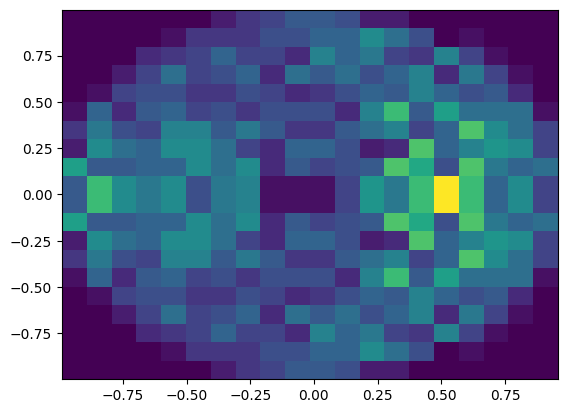

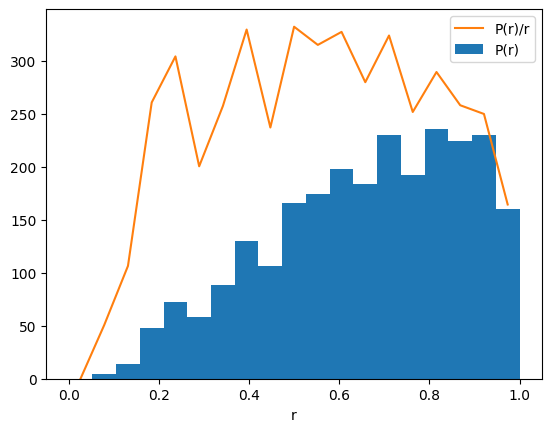

In [18]:
plt.hist2d(np.real(z_target_list2), np.imag(z_target_list2), bins=20)
plt.show()
bins = np.linspace(0, 1, 20)
bins_center = (bins[1:] + bins[:-1])/2
radial = plt.hist(np.abs(z_target_list2), bins=bins)[0]
plt.plot(bins_center, radial/bins_center)
plt.legend(["P(r)/r", "P(r)"])
plt.xlabel("r")
plt.show()

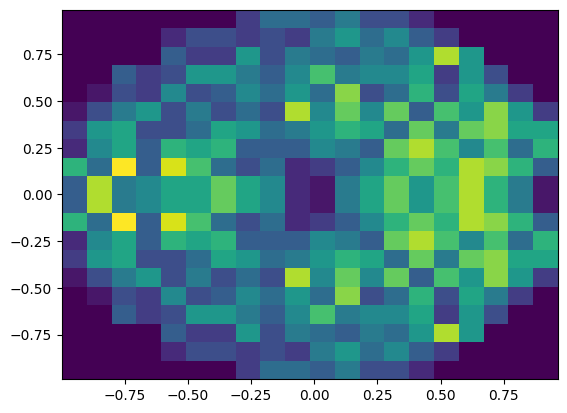

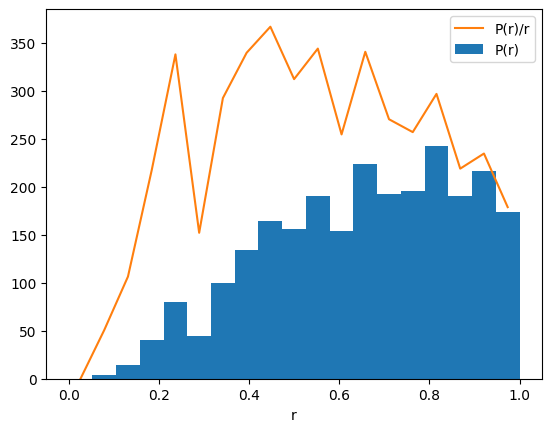

In [19]:
plt.hist2d(np.real(z_model_list2), np.imag(z_model_list2), bins=20)
plt.show()
bins = np.linspace(0, 1, 20)
bins_center = (bins[1:] + bins[:-1])/2
radial = plt.hist(np.abs(z_model_list2), bins=bins)[0]
plt.plot(bins_center, radial/bins_center)
plt.legend(["P(r)/r", "P(r)"])
plt.xlabel("r")
plt.show()